In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io
import itertools

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset
import wandb

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
import data_analysis.visualization.publication as publication
import simulate
import two_points

import models as models
from models import MLP, CNN, ResNet

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
## Load settings
settings = "default"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)
if nonlinearity == "discontinuous":
    nonlinearity = simulate.Discontinuous.apply
elif nonlinearity == "none":
    nonlinearity = None
else:
    nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [3]:
## Generate data
input_dim, output_dim = 1, 1

inputs = np.array([[-1] * input_dim, [-1 + np.sqrt(dx2)] * input_dim]) / np.sqrt(
    input_dim
)
outputs = np.array([[0.6] * output_dim, [0.6 + np.sqrt(dy2)] * output_dim]) / np.sqrt(
    output_dim
)
names = ["A", "B"]
data = TensorDataset(
    torch.from_numpy(inputs.astype(np.float32)).to(device),
    torch.from_numpy(outputs.astype(np.float32)).to(device),
)

encoding = Encoding(dict(zip(names, inputs)))

train_datasets = [data]
val_dataset = [data]

tracked_datasets = val_dataset + train_datasets

In [4]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=input_dim,
    output_size=output_dim,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
    non_linearity=nonlinearity,
)

In [5]:
## Setup compiler

# Define Loss, Optimizer
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], datasets=tracked_datasets
    ),
}
for l in range(L):
    compiler.trackers[f"hidden_{l}"] = ActivationTracker(
        model, lambda inputs, l=l: model(inputs)[1][l], datasets=tracked_datasets
    )

In [6]:
## Training run
compiler.training_run(
    train_datasets,
    tracked_datasets,
    n_epochs=n_epochs,
    batch_size=100,
)

Training: 100%|██████████| 3000/3000 [05:57<00:00,  8.39steps/s, train_loss=0.00000, val_loss=0.00000]


In [7]:
data_output = compiler.trackers["output"].get_trace()
epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()
y_A = [
    np.array(data.loc[epoch, 0, "A"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_B = [
    np.array(data.loc[epoch, 0, "B"])
    for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
]
y_true_A, y_true_B = outputs[0], outputs[1]
dy2 = np.sum((y_true_B - y_true_A) ** 2)
y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
w = np.array(
    [
        y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
        for epoch in epochs
    ]
)

eta_hs, eta_ys, losses = [], [], []
for l in trange(L):
    data_hid = compiler.trackers[f"hidden_{l}"].get_trace()
    epochs = list(set(data_output.index.get_level_values("Epoch")))
    epochs.sort()

    h_A = [
        np.array(data.loc[epoch, 0, "A"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]
    h_B = [
        np.array(data.loc[epoch, 0, "B"])
        for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
    ]

    h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])

    ## Fit effective learning rates
    eta_h_opt, eta_y_opt, loss = simulate.optimize_eta(
        h2, y2, w, dx2, dy2, guesses=np.logspace(-6, 2, 100)
    )
    eta_hs.append(eta_h_opt)
    eta_ys.append(eta_y_opt)
    losses.append(loss)

  5%|▌         | 1/20 [00:18<05:51, 18.52s/it]

Loss: 1.4585150608727835


 10%|█         | 2/20 [00:23<03:05, 10.31s/it]

Loss: 1.4123582171668456


 15%|█▌        | 3/20 [00:35<03:09, 11.14s/it]

Loss: 1.3153159301191881


 20%|██        | 4/20 [00:38<02:07,  8.00s/it]

Loss: 1.1618357884999149


 25%|██▌       | 5/20 [00:43<01:45,  7.02s/it]

Loss: 0.9817859798970464


 30%|███       | 6/20 [00:47<01:23,  5.98s/it]

Loss: 0.7522251223825654


 35%|███▌      | 7/20 [00:51<01:10,  5.39s/it]

Loss: 0.5030557880166553


 40%|████      | 8/20 [00:55<00:59,  4.93s/it]

Loss: 0.3297196011980172


 45%|████▌     | 9/20 [01:05<01:10,  6.37s/it]

Loss: 0.18662267075687772


 50%|█████     | 10/20 [01:11<01:04,  6.41s/it]

Loss: 0.09670921954655462


 55%|█████▌    | 11/20 [01:16<00:53,  5.92s/it]

Loss: 0.04468345451482508


 60%|██████    | 12/20 [01:20<00:41,  5.21s/it]

Loss: 0.016812839742805927


 65%|██████▌   | 13/20 [01:24<00:35,  5.08s/it]

Loss: 0.007801578131819281


 70%|███████   | 14/20 [01:31<00:32,  5.38s/it]

Loss: 0.006768471444945742


 75%|███████▌  | 15/20 [01:36<00:26,  5.30s/it]

Loss: 0.0073183866343205445


 80%|████████  | 16/20 [01:40<00:20,  5.08s/it]

Loss: 0.006717528050077968


 85%|████████▌ | 17/20 [01:47<00:16,  5.51s/it]

Loss: 0.008027336891309023


 90%|█████████ | 18/20 [01:52<00:10,  5.29s/it]

Loss: 0.017414511803475967


 95%|█████████▌| 19/20 [01:58<00:05,  5.54s/it]

Loss: 0.04784272081297051


100%|██████████| 20/20 [02:03<00:00,  6.18s/it]

Loss: 0.10762715503657444


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


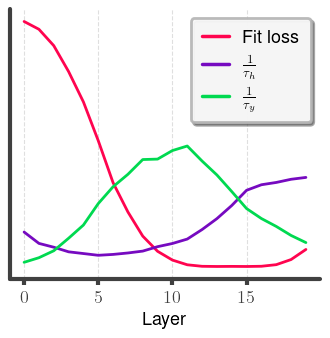

In [85]:
losses, eta_hs, eta_ys = [np.array(a) for a in [losses, eta_hs, eta_ys]]

publication.set_color_mixed(1)

fig = plt.figure(figsize=(4, 3.5))


plt.plot(losses, label="Fit loss")
plt.plot(100 * eta_hs, label=r"$\frac{1}{\tau_h}$")
plt.plot(10 * eta_ys, label=r"$\frac{1}{\tau_y}$")
plt.xlabel("Layer")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_visible(False)
publication.plt_show(save_path="plots/2_points/architecture/depth")